In [2]:
import numpy as np
import cv2
from os import listdir
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import classification_report, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.cross_validation import StratifiedKFold
import xgboost as xgb
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
X = [] # матрица признаков 
Y = [] # номер класса объекта
s = 10 # половина ширины окна
for i in range(6):
    for f in listdir(str(i)):
        img = plt.imread(str(i) + "/" + f)
        if len(img.shape) == 3:
            img = np.sum(img, axis=2) / 3
        h, w = img.shape
        if h > w:
            img = img.T
        cut1 = img[h//2 - s: h//2 + s, w//2 - s : w//2 + s] # вырезаем квадрат из центра
        cut2 = img[-2*s:, w//2 - s : w//2 + s]              # вырезаем квадрат из центра сверху
        cut3 = img[:2*s,  w//2 - s : w//2 + s]              # вырезаем квадрат из центра снизу
        X.append(np.hstack((cut1.flatten(), cut2.flatten(), cut3.flatten())))
        Y.append(i)
        # Аналогично добавляем признаки для веревернутого изображения
        # чтобы перевернутые изображение из теста распознавались верно
        up_down_img = np.flipud(img)
        cut1 = up_down_img[h//2 - s: h//2 + s, w//2 - s : w//2 + s]
        cut2 = up_down_img[-2*s:, w//2 - s : w//2 + s]
        cut3 = up_down_img[:2*s,  w//2 - s : w//2 + s]
        X.append(np.hstack((cut1.flatten(), cut2.flatten(), cut3.flatten())))
        Y.append(i)
X = np.array(X)
Y = np.array(Y).reshape(-1, 1)
print("Train dataset size: ", X.shape)

Train dataset size:  (14000, 1200)


In [4]:
path = "/home/einstalek/Datasets/miptcv/Merged/"
X_test = [] # объекты тестовой выборки
ss = pd.read_csv("sampleSubmission.csv")
test_names = []
for f in ss["# fname"]:
    test_names.append(f)
    img = plt.imread(path + f)
    if len(img.shape) == 3:
        img = np.sum(img, axis=2) / 3
    h, w = img.shape
    if h > w:
        # Если нужно, переворачиваем изображение в тесте
        img = img.T
    h, w = img.shape
    cut1 = img[h//2 - s: h//2 + s, w//2 - s : w//2 + s] # вырезаем квадрат из центра
    cut2 = img[-2*s:, w//2 - s : w//2 + s]              # вырезаем квадрат из центра сверху
    cut3 = img[:2*s,  w//2 - s : w//2 + s]              # вырезаем квадрат из центра снизу
    X_test.append(np.hstack((cut1.flatten(), cut2.flatten(), cut3.flatten())))
X_test = np.array(X_test)
print("Test dataset size: ", X_test.shape)

Test dataset size:  (1750, 1200)


In [5]:
# Понижаем размерность до 2
X_all = np.vstack([X, X_test])
print("Original dataset size: ", X_all.shape)
# Сначала уменьшаем размерность с помощью CPA до 100
pca = PCA(n_components=100, random_state=0)
X_all_pca = pca.fit_transform(X_all)
# Далее уменьшаем размерность с помощью tsne до 2
tsne = TSNE(n_components=2, random_state=0)
X_all_2 = tsne.fit_transform(X_all_pca)
print("Transformed dataset size: ", X_all_2.shape)

Original dataset size:  (15750, 1200)
Transformed dataset size:  (15750, 2)


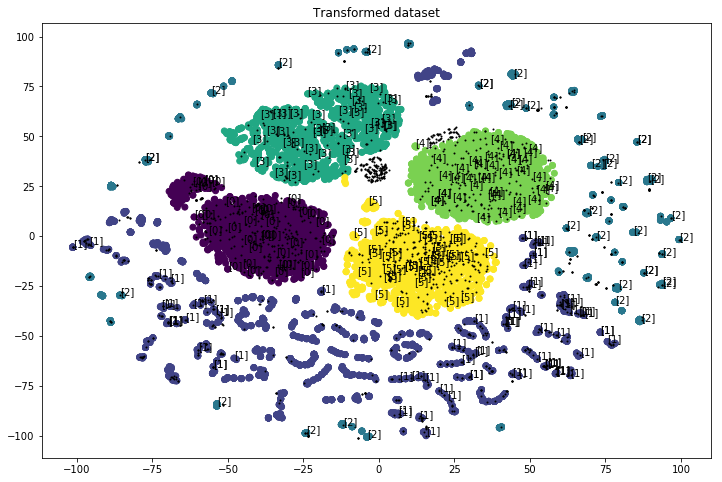

In [6]:
# Выборка (train + test) в новом признаковом пространстве
# Видно, что классы неплохо разделяются
# Монжо заметить, что классы 1 и 2 разделяются чуть хуже
# А еще вблизи кластера класса 3 есть какое-то выделенное облако точек из test-выборки
# А еще есть несколько объектов класса 5 которые лежат ближе к кластеру класса 3 
plt.figure(figsize=(12, 8))
plt.title("Transformed dataset")
plt.scatter(X_all_2[:14000, 0], X_all_2[:14000, 1], c=Y)
plt.scatter(X_all_2[14000:, 0], X_all_2[14000:, 1],  c="black", s=1)
for i in range(0, 14000, 50):
    x, y = X_all_2[i]
    plt.text(x, y, str(Y[i]));

In [7]:
train, test, y_train, y_test = train_test_split(X_all_2[:14000], Y, train_size=0.85, random_state=0)

In [102]:
# Настраиваем случайный лес над двумерной выборкой
param_grid = {"n_estimators": [50, 80, 100, 150, 170], 
              "max_depth": [8,10, 12, 15]
             }
cv = StratifiedKFold(y_train.ravel(), n_folds=5, shuffle=True, random_state=0)
rf = RandomForestClassifier(random_state=0)
gsearch = GridSearchCV(rf, param_grid, n_jobs=3, cv=cv)
gsearch.fit(train, y_train.ravel());
rf = gsearch.best_estimator_
rf

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [8]:
rf.fit(train, y_train.ravel());

In [10]:
# Настраиваем xgboost над двумерной выборкой
param_grid = {"n_estimators": [40, 50, 80], 
              "max_depth": [5, 6, 7]
             }
cv = StratifiedKFold(y_train.ravel(), n_folds=3, shuffle=True, random_state=0)
gb = xgb.XGBClassifier(seed=0, nthread=1)
gsearch = GridSearchCV(gb, param_grid, n_jobs=1, cv=cv)
gsearch.fit(train, y_train.ravel());
gb = gsearch.best_estimator_
gb

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=5,
       min_child_weight=1, missing=None, n_estimators=80, nthread=1,
       objective='multi:softprob', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

In [11]:
gb.fit(train, y_train.ravel());

In [12]:
def plot_decision_boundary(model, X, y):
    """Рисует decision boundary и точки из выборки"""
    plt.figure(figsize=(12, 6))
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    h = 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, c=y)
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors="black")

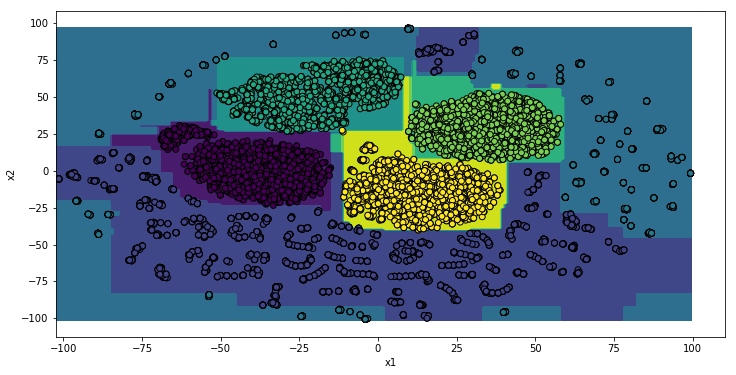

In [13]:
# Decision boundary for random forest
plot_decision_boundary(gb, train, y_train)

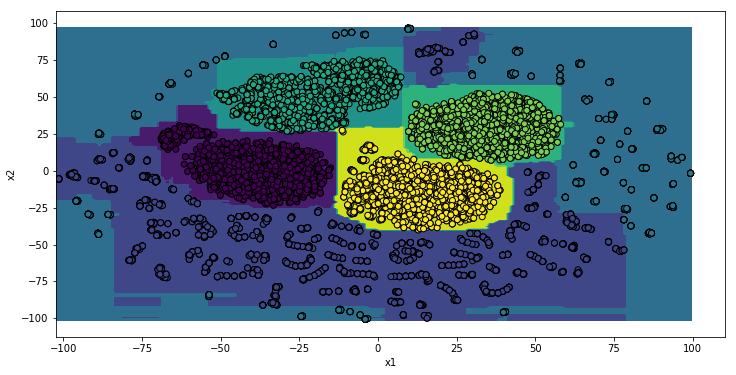

In [14]:
# Decision boundary for xgboost
plot_decision_boundary(rf, train, y_train)

In [21]:
# Посылаем предсказания xgboost
# Результат на LB: 0.99885
predictions = gb.predict(X_all_2[14000:])
ans = pd.DataFrame({"# fname": test_names, "class": p})
preds = ans.sort_values(by="# fname")["class"].values
ans.to_csv("subm.csv", index=False)